In [1]:
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt

from data import *
from nnet import Model
from sklearn.metrics import roc_auc_score

C:\Users\ASUS\Anaconda3\envs\frog\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")



 Loaded Word_embeddings Matrix (48098, 300)
 Loaded Vocabulary Mapping (size 48098)

 Loaded wid corpus (all)

 Loaded wid corpus (train)

 Loaded wid corpus (dev)

 Loaded wid corpus (test)


In [ ]:
def subplot_hist(num, content1, content2, weights1, weights2, xmin=0., xmax=1., ymin=0., ymax=1., xlabel='', title=''):
    plt.subplot(num)
    n2, bins2, patches2 = plt.hist(content2, 150, facecolor='r', alpha=0.75, weights=weights2) # q1 and q2 not duplicates
    n1, bins1, patches1 = plt.hist(content1, 75, facecolor='g', alpha=0.75, weights=weights1) # q1 and q2 duplicates
    plt.xlabel(xlabel)
    plt.ylabel('Normalized counts')
    plt.axis([xmin, xmax, ymin, ymax])
    plt.title(title)


def plot_hist(w2s1, w2s2, mah1, mah2, title=''):
    # Get metric power
    y = [-1]*len(w2s1) + [1]*len(w2s2)
    scores = w2s1 + w2s2
    print('W2 AUC: {}'.format(roc_auc_score(y, scores)))

    y = [-1]*len(mah1) + [1]*len(mah2)
    scores = mah1 + mah2
    print('Mah AUC: {}'.format(roc_auc_score(y, scores)))
 
    # Plot density like histograms (sum=1)
    w1 = np.ones_like(w2s1)/float(len(w2s1))
    w2 = np.ones_like(w2s2)/float(len(w2s2))

    plt.rcParams['figure.figsize'] = [10, 5]
    plt.figure(1)
    subplot_hist(111, np.array(w2s1), np.array(w2s2), w1, w2, xmax=500, ymax=0.15, xlabel='W2(q1,q2)', title=title) # Wasserstein 2 distance
    #subplot_hist(212, np.array(mah1), np.array(mah2), w1, w2, xmax=500, ymax=0.1, xlabel='Mah(q1,q2)', title=title) # Mahalanobis distance
    plt.savefig('../../insights/proposal/discriminative_power/{}.png'.format(title))
    plt.show()

In [2]:
def build_graph(batch_size=128, padlen=40):
    tf.reset_default_graph()
    model = Model(embedding_weights=weights, build_decoder=False, batch_size=batch_size, padlen=padlen) # Build tensorflow graph from config
    variables_to_save = [v for v in tf.global_variables() if 'Adam' not in v.name and 'global_step' not in v.name and 'vad' not in v.name] # Saver to save & restore all the variables.
    saver = tf.train.Saver(var_list=variables_to_save, keep_checkpoint_every_n_hours=1.0) # CLF saver
    return model, saver

  
def eval(model, saver, Xs, Ys, Xa, Ya, pretrain='VAD', clf_nepochs=3, batch_size=128, padlen=40):
    ns, na = len(Xs), len(Xa)
    ratio = ns/(ns+na)
    w2s, mahs, predictions = {'s':[],'a':[]}, {'s':[],'a':[]}, {'s':[],'a':[]}

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # run init op
        saver.restore(sess, '{}/_deepNLU/save/{}SIAM{}/actor.ckpt'.format(dir_,pretrain,clf_nepochs)) # Restore variables from disk.
        print('\n Restored {}SIAM{}'.format(pretrain,clf_nepochs))

        ''' Eval True paraphrases '''

        batches = create_batches(ns, batch_size=batch_size, shuffle=False)
        batches.append(np.arange(np.floor(ns/batch_size).astype(int)*batch_size, ns))
        
        q, q_len = {}, {}
        for i, idx_batch in enumerate(batches):
            q1_, q2_, q1_len_, q2_len_ = [], [], [], []
            for j in idx_batch:
                q1_j, q1_len_j = pad_sequence(list(Xs[j]), padlen=padlen) 
                q2_j, q2_len_j = pad_sequence(list(Ys[j]), padlen=padlen)
                q1_.append(q1_j)
                q2_.append(q2_j)
                q1_len_.append(q1_len_j)
                q2_len_.append(q2_len_j)
            q[i] = np.concatenate([np.stack(q1_, axis=0), np.stack(q2_, axis=0)], axis=0)
            q_len[i] = np.concatenate([np.stack(q1_len_, axis=0), np.stack(q2_len_, axis=0)], axis=0)

        for i in tqdm(np.arange(len(batches))):
            feed = {model.q1: q[i], model.len1: q_len[i]}
            W2_dist, Mah_dist, predict = sess.run([model.W2_dist, model.Mah_dist, model.predict], feed_dict=feed) # Forward pass
            w2s['s'] += list(W2_dist)
            mahs['s'] += list(Mah_dist)
            predictions['s'] += list(predict)

        ''' Eval False paraphrases '''
        batches = create_batches(na, batch_size=batch_size, shuffle=False)
        batches.append(np.arange(np.floor(na/batch_size).astype(int)*batch_size, na))
        
        q, q_len = {}, {}
        for i, idx_batch in enumerate(batches):
            q1_, q2_, q1_len_, q2_len_ = [], [], [], []
            for j in idx_batch:
                q1_j, q1_len_j = pad_sequence(list(Xa[j]), padlen=padlen) 
                q2_j, q2_len_j = pad_sequence(list(Ya[j]), padlen=padlen)
                q1_.append(q1_j)
                q2_.append(q2_j)
                q1_len_.append(q1_len_j)
                q2_len_.append(q2_len_j)
            q[i] = np.concatenate([np.stack(q1_, axis=0), np.stack(q2_, axis=0)], axis=0)
            q_len[i] = np.concatenate([np.stack(q1_len_, axis=0), np.stack(q2_len_, axis=0)], axis=0)

        for i in tqdm(np.arange(len(batches))):
            feed = {model.q1: q[i], model.len1: q_len[i]}
            W2_dist, Mah_dist, predict = sess.run([model.W2_dist, model.Mah_dist, model.predict], feed_dict=feed) # Forward pass
            w2s['a'] += list(W2_dist)
            mahs['a'] += list(Mah_dist)
            predictions['a'] += list(predict)

    TP = np.mean(np.array(predictions['s']))
    FN = np.mean(np.array(predictions['a']))
    accuracy = ratio*TP+(1-ratio)*(1-FN)
    print('\n Eval COMPLETED ! {:.4f} TP ({} pairs), {:.4f} FN ({} pairs), {:.4f} accuracy ({} pairs {:.4f} bias)'.format(100*TP, ns, 100*FN, na, 100*accuracy, ns+na, 100*(1-ratio)))

    return w2s, mahs, predictions  

In [3]:
semantic_power = {}

In [4]:
padlen_ = 40
batch_size_ = 128

## Run session

In [7]:
for set_name_ in ['DEV']: # TEST
    print('\n Evaluation on Quora {} set'.format(set_name_))
    if set_name_=='DEV':
        Xs, Ys, Xa, Ya = Xs_dev_ids, Ys_dev_ids, Xa_dev_ids, Ya_dev_ids
    else:
        Xs, Ys, Xa, Ya = Xs_test_ids, Ys_test_ids, Xa_test_ids, Ya_test_ids

    for pretrain_ in ['VAD']: #VAD
        for clf_nepochs_ in [3]: # 0,3
            model, saver = build_graph(batch_size=batch_size_, padlen=padlen_)
            w2s, mahs, predictions = eval(model, saver, Xs, Ys, Xa, Ya, pretrain=pretrain_, clf_nepochs=clf_nepochs_, batch_size=batch_size_, padlen=padlen_) # Dev dataset
            semantic_power['Quora{}:: {}SIAM{} '.format(set_name_, pretrain_, clf_nepochs_)] = w2s, mahs, predictions


 Evaluation on Quora DEV set
INFO:tensorflow:Restoring parameters from ../_deepNLU/save/VADSIAM3/actor.ckpt


2018-10-05 13:47:45,831 : INFO : Restoring parameters from ../_deepNLU/save/VADSIAM3/actor.ckpt



 Restored VADSIAM3


100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [04:55<00:00,  6.04s/it]



 Eval COMPLETED ! 85.8087 TP (3784 pairs), 8.9783 FN (6215 pairs), 89.0489 accuracy (9999 pairs 62.1562 bias)


## Print / plot results 

QuoraDEVVADSIAM3 
W2 AUC: 0.8687818591724652
Mah AUC: 0.8878119796441467


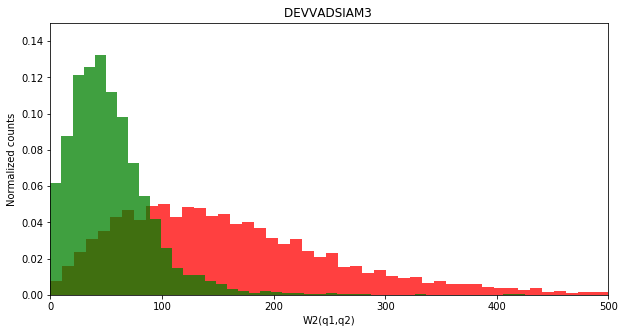

QuoraTESTVADSIAM3 
W2 AUC: 0.8626771340648628
Mah AUC: 0.8798389538279014


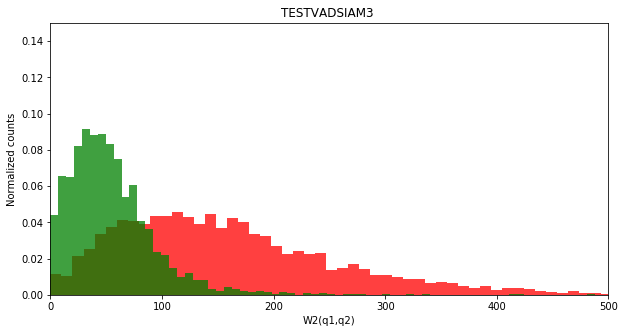

In [8]:
for k, (w,m,p) in semantic_power.items():
    k = k.replace(':: ','')
    print(k)
    if '0' not in k:
        plot_hist(w['s'], w['a'], m['s'], m['a'], title=k[5:])